## Environment Setup

In [ ]:
# def setup_environment():
#   try:
#       # Check if running in Google Colab
#       import google.colab
#       from google.colab import drive
#       drive.mount('/content/drive')
#       folder_path = 'drive/MyDrive/ENSF612Project'
#       print("Running in Google Colab. Folder path:", folder_path)
#   except ImportError:
#       folder_path = '.'
#       print("Running locally: Folder path:", folder_path)
#   return folder_path

# folder_path = setup_environment()

Check that `train.csv` and `test.csv` are visible in the given environment (Note that if running locally, these files must be in the same directory).

In [ ]:
# !ls drive/MyDrive/ENSF612Project

AirlineDelays.ipynb	  AirlineDelays_Ryan.ipynb  test.csv
AirlineDelays_Rhys.ipynb  AirlineDelays_Tom.ipynb   train.csv


In [ ]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !pip install pyspark

## Spark Initialization

In [2]:
import pyspark
from pyspark.sql import SparkSession

def initialize_spark():
    spark = SparkSession.builder \
        .config("spark.executor.memory", "8g") \
        .config("spark.driver.memory", "8g") \
        .config("spark.driver.host", "127.0.0.1") \
        .config("spark.driver.port", "5001") \
        .getOrCreate()
    sc = spark.sparkContext
    sc.setLogLevel("WARN")
    return spark

spark = initialize_spark()

## Data Loading

In [3]:
folder_path = '.'

def load_data(spark, folder_path, train_file="train.csv", test_file="test.csv"):
  train_df = spark.read.csv(f"{folder_path}/{train_file}", header=True, inferSchema=True)
  test_df = spark.read.csv(f"{folder_path}/{test_file}", header=True, inferSchema=True)
  return train_df, test_df

train_df, test_df = load_data(spark, folder_path)

## Preprocessing Pipeline

In [5]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

def preprocess_data(train_df, test_df, target_column, numeric_features, string_features):
    # Define stages
    string_indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in string_features]
    one_hot_encoders = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_one_hot") for col in string_features]
    numeric_assembler = VectorAssembler(inputCols=numeric_features, outputCol="numeric_features")
    scaler = StandardScaler(inputCol="numeric_features", outputCol="numeric_features_scaled", withMean=True, withStd=True)
    label_indexer = StringIndexer(inputCol=target_column, outputCol="label")

    # Pipeline
    stages = string_indexers + one_hot_encoders + [numeric_assembler, scaler, label_indexer]
    pipeline = Pipeline(stages=stages)

    # Fit and transform
    pipeline_model = pipeline.fit(train_df)
    train_transformed = pipeline_model.transform(train_df)
    test_transformed = pipeline_model.transform(test_df)
    return train_transformed, test_transformed

numeric_features = [
    "MONTH",
    "DAY_OF_WEEK",
    "DISTANCE_GROUP",
    "SEGMENT_NUMBER",
    "CONCURRENT_FLIGHTS",
    "NUMBER_OF_SEATS",
    "AIRPORT_FLIGHTS_MONTH",
    "AIRLINE_AIRPORT_FLIGHTS_MONTH",
    "AVG_MONTHLY_PASS_AIRPORT",
    "AVG_MONTHLY_PASS_AIRLINE",
    "FLT_ATTENDANTS_PER_PASS",
    "GROUND_SERV_PER_PASS",
    "PLANE_AGE",
    "LATITUDE",
    "LONGITUDE",
    "PRCP",
    "SNOW",
    "SNWD",
    "TMAX",
    "AWND",
    "CARRIER_HISTORICAL",
    "DEP_AIRPORT_HIST",
    "DAY_HISTORICAL",
    "DEP_BLOCK_HIST"
]
string_features = [
    'DEP_TIME_BLK',
    'CARRIER_NAME',
    'DEPARTING_AIRPORT',
    'PREVIOUS_AIRPORT'
]
train_transformed, test_transformed = preprocess_data(train_df, test_df, "DEP_DEL15", numeric_features, string_features)
train_transformed.groupBy("label").count().show()


+-----+-------+
|label|  count|
+-----+-------+
|  0.0|3683185|
|  1.0| 859158|
+-----+-------+



## Correlation matrix

Correlations with Target (DEP_DEL15):
                               Correlation
DEP_BLOCK_HIST                    0.198331
CARRIER_HISTORICAL                0.121155
SEGMENT_NUMBER                    0.117343
DEP_AIRPORT_HIST                  0.099611
DAY_HISTORICAL                    0.097732
PRCP                              0.080107
AWND                              0.050869
SNOW                              0.050233
LONGITUDE                         0.027445
AIRPORT_FLIGHTS_MONTH             0.026883
SNWD                              0.026275
AVG_MONTHLY_PASS_AIRPORT          0.024386
DISTANCE_GROUP                    0.015998
AIRLINE_AIRPORT_FLIGHTS_MONTH     0.013950
NUMBER_OF_SEATS                   0.011734
CONCURRENT_FLIGHTS                0.009380
PLANE_AGE                         0.006335
AVG_MONTHLY_PASS_AIRLINE          0.001158
LATITUDE                          0.000140
DAY_OF_WEEK                      -0.000030
FLT_ATTENDANTS_PER_PASS          -0.002286
TMAX            

C:\Users\rhysw\AppData\Local\Temp\ipykernel_24208\4205954738.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.index, y=correlation_with_target["Correlation"], palette="coolwarm")


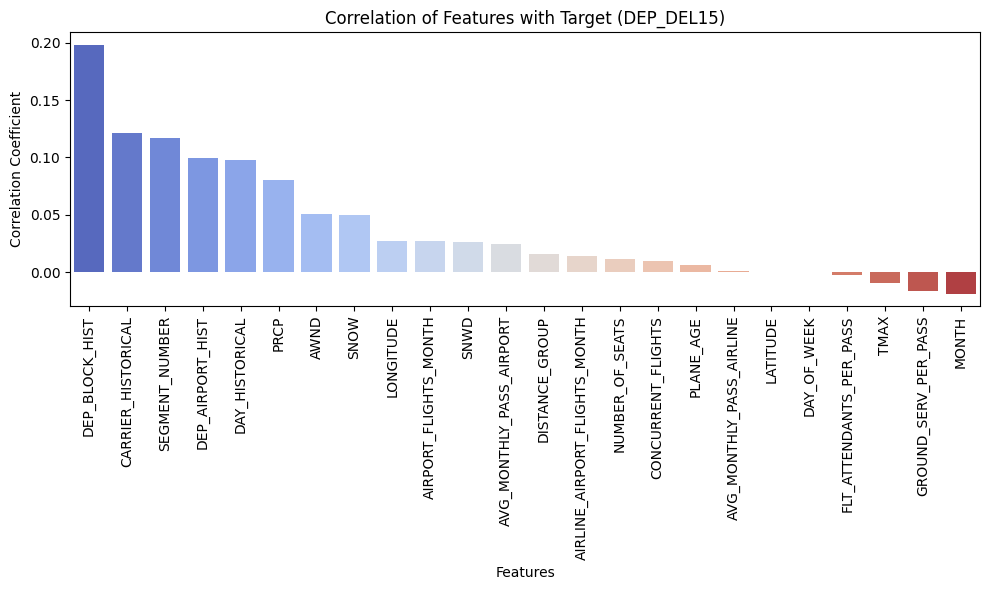

In [7]:
from pyspark.sql.functions import col
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter numeric features
selected_features = numeric_features + ["DEP_DEL15"]

# Compute Pearson correlation for numeric features and target separately
correlations = {}
for feature in numeric_features:
    correlation_value = train_df.stat.corr(feature, "DEP_DEL15")
    correlations[feature] = correlation_value

# Convert to pandas DataFrame for easier visualization
correlation_with_target = pd.DataFrame.from_dict(correlations, orient="index", columns=["Correlation"])
correlation_with_target = correlation_with_target.sort_values(by="Correlation", ascending=False)

# Display correlations with the target
print("Correlations with Target (DEP_DEL15):")
print(correlation_with_target)

# Optionally: Plot a bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.index, y=correlation_with_target["Correlation"], palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Correlation of Features with Target (DEP_DEL15)")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.tight_layout()
plt.show()


## Model Training and Evaluation

In [10]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def train_and_evaluate(train_data, test_data, classifier, feature_col="numeric_features_scaled"):
    # Add classifier to pipeline
    classifier.setFeaturesCol(feature_col).setLabelCol("label")
    pipeline = Pipeline(stages=[classifier])
    model = pipeline.fit(train_data)

    # Predictions
    train_predictions = model.transform(train_data)
    test_predictions = model.transform(test_data)

    # Evaluation
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    train_accuracy = evaluator.evaluate(train_predictions)
    test_accuracy = evaluator.evaluate(test_predictions)

    print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return model, train_predictions, test_predictions

# Example: Logistic Regression, Random Forest, and Multilayer Perceptron
lr = LogisticRegression(maxIter=10, regParam=0.1)
rf = RandomForestClassifier(numTrees=100)
mlp = MultilayerPerceptronClassifier(layers=[len(numeric_features), 10, 2])  # Example layer sizes

# Store predictions for all classifiers
predictions = {}
for classifier in [lr, rf, mlp]:
    model_name = classifier.__class__.__name__
    print(f"Evaluating {model_name}...")
    model, train_preds, test_preds = train_and_evaluate(train_transformed, test_transformed, classifier)
    predictions[model_name] = {"train": train_preds, "test": test_preds, "model": model}


Evaluating LogisticRegression...
Train Accuracy: 0.8110, Test Accuracy: 0.8110
Evaluating RandomForestClassifier...
Train Accuracy: 0.8109, Test Accuracy: 0.8109
Evaluating MultilayerPerceptronClassifier...
Train Accuracy: 0.8131, Test Accuracy: 0.8129


## Confusion Matrix

In [11]:
from pyspark.sql import functions as F

def compute_metrics(predictions, label_col="label", prediction_col="prediction", positive_class=1):
    # Create confusion matrix components
    tp = predictions.filter((F.col(label_col) == positive_class) & (F.col(prediction_col) == positive_class)).count()
    tn = predictions.filter((F.col(label_col) != positive_class) & (F.col(prediction_col) != positive_class)).count()
    fp = predictions.filter((F.col(label_col) != positive_class) & (F.col(prediction_col) == positive_class)).count()
    fn = predictions.filter((F.col(label_col) == positive_class) & (F.col(prediction_col) != positive_class)).count()

    # Confusion matrix
    print("Confusion Matrix:")
    print(f"TP: {tp}, FP: {fp}")
    print(f"FN: {fn}, TN: {tn}")

    # Precision, Recall, and F1 Score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print("-" * 40)

# Iterate through all classifiers and calculate metrics
for name, preds in predictions.items():
    print(f"Metrics for {name} on Test Data:")
    compute_metrics(preds["test"], label_col="label", prediction_col="prediction", positive_class=1)



Metrics for LogisticRegression on Test Data:
Confusion Matrix:
TP: 1341, FP: 1094
FN: 366869, TN: 1577415
Precision: 0.5507
Recall: 0.0036
F1 Score: 0.0072
----------------------------------------
Metrics for RandomForestClassifier on Test Data:
Confusion Matrix:
TP: 0, FP: 0
FN: 368210, TN: 1578509
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
----------------------------------------
Metrics for MultilayerPerceptronClassifier on Test Data:
Confusion Matrix:
TP: 15400, FP: 11437
FN: 352810, TN: 1567072
Precision: 0.5738
Recall: 0.0418
F1 Score: 0.0780
----------------------------------------


Feature Importances:
                          Feature  Importance
23                 DEP_BLOCK_HIST    0.354622
21               DEP_AIRPORT_HIST    0.142808
3                  SEGMENT_NUMBER    0.127744
15                           PRCP    0.102181
20             CARRIER_HISTORICAL    0.088698
16                           SNOW    0.071182
22                 DAY_HISTORICAL    0.053766
7   AIRLINE_AIRPORT_FLIGHTS_MONTH    0.010170
18                           TMAX    0.009459
8        AVG_MONTHLY_PASS_AIRPORT    0.008922
0                           MONTH    0.008821
6           AIRPORT_FLIGHTS_MONTH    0.005840
19                           AWND    0.004397
17                           SNWD    0.004235
14                      LONGITUDE    0.002202
11           GROUND_SERV_PER_PASS    0.001782
4              CONCURRENT_FLIGHTS    0.001635
13                       LATITUDE    0.000750
9        AVG_MONTHLY_PASS_AIRLINE    0.000377
1                     DAY_OF_WEEK    0.000288
5            

C:\Users\rhysw\AppData\Local\Temp\ipykernel_24208\305255757.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances_df, x="Importance", y="Feature", palette="viridis")


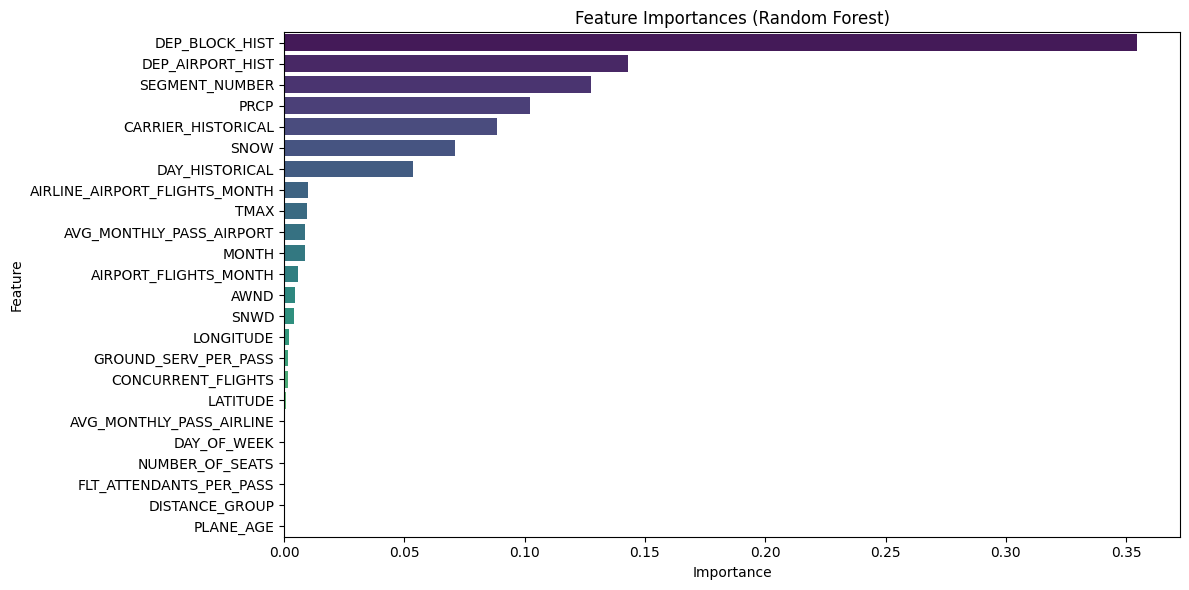

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature importances for Random Forest
rf_model = predictions["RandomForestClassifier"]["model"].stages[-1]  # Get the RandomForest stage
feature_importances = rf_model.featureImportances.toArray()

# Map feature importances to the feature names
feature_importances_df = pd.DataFrame({
    "Feature": numeric_features,  # List of feature names
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Print feature importances
print("Feature Importances:")
print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importances_df, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
# Logistic regression with regParam 1 
lr2 = LogisticRegression(maxIter=10, regParam=1)

model_lr2, train_preds_lr2, test_preds_lr2 = train_and_evaluate(train_transformed, test_transformed, lr2)
compute_metrics(test_preds_lr2)

Train Accuracy: 0.8109, Test Accuracy: 0.8109
Confusion Matrix:
TP: 0, FP: 0
FN: 368210, TN: 1578509
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
----------------------------------------


In [ ]:
# Logistic regression with regParam 0.01
lr3 = LogisticRegression(maxIter=10, regParam=0.01)

model_lr3, train_preds_lr3, test_preds_lr3 = train_and_evaluate(train_transformed, test_transformed, lr3)
compute_metrics(test_preds_lr3)

Train Accuracy: 0.8114, Test Accuracy: 0.8114
Confusion Matrix:
TP: 5973, FP: 5001
FN: 362237, TN: 1573508
Precision: 0.5443
Recall: 0.0162
F1 Score: 0.0315
----------------------------------------


In [13]:
# Logistic regression with regParam 0.001
lr4 = LogisticRegression(maxIter=1000, regParam=0.001)

model_lr4, train_preds_lr4, test_preds_lr4 = train_and_evaluate(train_transformed, test_transformed, lr4)
compute_metrics(test_preds_lr4)

Train Accuracy: 0.8113, Test Accuracy: 0.8113
Confusion Matrix:
TP: 7365, FP: 6439
FN: 360845, TN: 1572070
Precision: 0.5335
Recall: 0.0200
F1 Score: 0.0386
----------------------------------------


In [15]:
# mlp with more layers, more iterations, and smaller learning rate
mlp2 = MultilayerPerceptronClassifier(
    layers=[len(numeric_features), 50, 20, 2],  # Larger architecture
    maxIter=200,                               # More iterations
    stepSize=0.01,                             # Smaller learning rate
)

mlp2, train_preds_mlp2, test_preds_mlp2 = train_and_evaluate(train_transformed, test_transformed, mlp2)
compute_metrics(test_preds_mlp2)

Train Accuracy: 0.8150, Test Accuracy: 0.8150
Confusion Matrix:
TP: 25725, FP: 17684
FN: 342485, TN: 1560825
Precision: 0.5926
Recall: 0.0699
F1 Score: 0.1250
----------------------------------------


In [ ]:
# Random forrest with weightCol parameter
from pyspark.sql.functions import when, col

# Calculate weights for the classes
class_counts = train_transformed.groupBy("label").count().collect()
majority_class_count = max(row["count"] for row in class_counts)
weights = {row["label"]: majority_class_count / row["count"] for row in class_counts}
print(weights)

# Add weight column to the training data
train_data_weighted = train_transformed.withColumn("weight", when(col("label") == 1, weights[1]).otherwise(weights[0]))

# Use the weight column in the RandomForestClassifier
rf2 = RandomForestClassifier(numTrees=100, weightCol="weight")

# Train and evaluate
model_rf2, train_preds_rf2, test_preds_rf2 = train_and_evaluate(train_data_weighted, test_transformed, rf2)
compute_metrics(test_preds_rf2)


Train Accuracy: 0.6022, Test Accuracy: 0.6025
Confusion Matrix:
TP: 242471, FP: 648045
FN: 125739, TN: 930464
Precision: 0.2723
Recall: 0.6585
F1 Score: 0.3853
----------------------------------------


In [ ]:
# Random forrest with weightCol parameter, adjust weights
weights = {0: 1.0, 1: 2.0}  # Adjust weights to prioritize recall while maintaining precision

train_data_weighted = train_transformed.withColumn(
    "weight", when(col("label") == 1, weights[1]).otherwise(weights[0])
)

# Use the weight column in the RandomForestClassifier
rf3 = RandomForestClassifier(numTrees=100, weightCol="weight")

# Train and evaluate
model_rf3, train_preds_rf3, test_preds_rf3 = train_and_evaluate(train_data_weighted, test_transformed, rf3)
compute_metrics(test_preds_rf3)

Train Accuracy: 0.8115, Test Accuracy: 0.8114
Confusion Matrix:
TP: 16978, FP: 15858
FN: 351232, TN: 1562651
Precision: 0.5171
Recall: 0.0461
F1 Score: 0.0847
----------------------------------------


In [ ]:
# Random forrest with weightCol parameter, adjust weights
weights = {0: 1, 1: 3.0}  # Adjust weights to prioritize recall while maintaining precision

train_data_weighted = train_transformed.withColumn(
    "weight", when(col("label") == 1, weights[1]).otherwise(weights[0])
)

# Use the weight column in the RandomForestClassifier
rf3 = RandomForestClassifier(numTrees=100, weightCol="weight")

# Train and evaluate
model_rf3, train_preds_rf3, test_preds_rf3 = train_and_evaluate(train_data_weighted, test_transformed, rf3)
compute_metrics(test_preds_rf3)

Train Accuracy: 0.7642, Test Accuracy: 0.7643
Confusion Matrix:
TP: 117255, FP: 207849
FN: 250955, TN: 1370660
Precision: 0.3607
Recall: 0.3184
F1 Score: 0.3382
----------------------------------------


In [ ]:
# feature_importances = model_rf2.stages[-1].featureImportances

# # Example list of feature names
# feature_names = numeric_features  # Replace with your actual feature names list

# # Pair feature names with their importance
# feature_importance_dict = list(zip(feature_names, feature_importances))

# # Sort by importance (descending order)
# sorted_features = sorted(feature_importance_dict, key=lambda x: x[1], reverse=True)

# # Display
# for feature, importance in sorted_features:
#     print(f"{feature}: {importance}")

In [ ]:
# weights = {0: 1, 1: 3.0}  # Adjust weights to prioritize recall while maintaining precision

# train_data_weighted = train_transformed.withColumn(
#     "weight", when(col("label") == 1, weights[1]).otherwise(weights[0])
# )

# # Use the weight column in the RandomForestClassifier
# rf3 = RandomForestClassifier(numTrees=100, maxDepth=15, featureSubsetStrategy="log2", weightCol="weight")

# # Train and evaluate
# model_rf3, train_preds_rf3, test_preds_rf3 = train_and_evaluate(train_data_weighted, test_transformed, rf3)
# compute_metrics(test_preds_rf3)

In [20]:
feature_importances = model_rf2.stages[-1].featureImportances
print("Feature Importances:", feature_importances)

Feature Importances: (24,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],[0.00726192894817795,7.526633913836861e-06,0.0013252201264470306,0.1408248726182614,0.0005140923495601671,0.001886059607902475,0.008961957578488925,0.0029865012800210137,0.01065021071670124,0.00633479615951054,0.0009471899032163822,0.0034032137424054787,5.073691264169398e-05,0.0011015660817078592,0.006071318991498746,0.09160603317605988,0.010120877893139195,0.0023196219112178165,0.002410508513319663,0.010320451194332805,0.1060649133649306,0.1126062250872355,0.04459375420778605,0.42763042300152415])


## Hyperparameter tuning

In [7]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

def cross_validate_and_evaluate(train_data, test_data, classifier, param_grid, evaluator, feature_col="numeric_features_scaled"):
    # Set up pipeline for each classifier
    classifier.setFeaturesCol(feature_col).setLabelCol("label")
    pipeline = Pipeline(stages=[classifier])

    # Cross-validation setup
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator,
                              numFolds=5)  # 5-fold cross-validation

    # Fit the model
    cv_model = crossval.fit(train_data)

    # Best model from cross-validation
    best_model = cv_model.bestModel

    # Get best parameters
    best_params = {param.name: best_model._java_obj.getParam(param.name).json() for param in best_model.params}

    # Get predictions
    train_predictions = best_model.transform(train_data)
    test_predictions = best_model.transform(test_data)

    # Evaluate the model
    train_accuracy = evaluator.evaluate(train_predictions)
    test_accuracy = evaluator.evaluate(test_predictions)

    # Extract prediction and label columns for metrics
    train_labels_and_preds = train_predictions.select("label", "prediction").rdd
    test_labels_and_preds = test_predictions.select("label", "prediction").rdd

    # Compute confusion matrix
    train_metrics = MulticlassMetrics(train_labels_and_preds)
    test_metrics = MulticlassMetrics(test_labels_and_preds)

    # Get confusion matrix
    train_conf_matrix = train_metrics.confusionMatrix().toArray()
    test_conf_matrix = test_metrics.confusionMatrix().toArray()

    # Get precision, recall, and F1 score
    train_precision = train_metrics.precision()
    test_precision = test_metrics.precision()
    
    train_recall = train_metrics.recall()
    test_recall = test_metrics.recall()
    
    train_f1 = train_metrics.fMeasure()
    test_f1 = test_metrics.fMeasure()

    # Print results
    print(f"{classifier.__class__.__name__} - Best Parameters: {best_params}")
    print(f"{classifier.__class__.__name__} - Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(f"{classifier.__class__.__name__} - Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}")
    print(f"{classifier.__class__.__name__} - Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}")
    print(f"{classifier.__class__.__name__} - Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")
    print(f"{classifier.__class__.__name__} - Train Confusion Matrix:\n{train_conf_matrix}")
    print(f"{classifier.__class__.__name__} - Test Confusion Matrix:\n{test_conf_matrix}")

    return best_model, best_params, train_accuracy, test_accuracy, train_conf_matrix, test_conf_matrix, train_precision, test_precision, train_recall, test_recall




In [ ]:
# # Logistic Regression Param Grid
# lr_param_grid = (ParamGridBuilder()
#                  .addGrid(lr.regParam, [0.1, 0.01])  # Regularization parameter
#                  .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])  # ElasticNet parameter
#                  .build())

# # Random Forest Param Grid
# rf_param_grid = (ParamGridBuilder()
#                  .addGrid(rf.numTrees, [50, 100, 200])  # Number of trees
#                  .addGrid(rf.maxDepth, [5, 10, 20])  # Max depth
#                  .build())

# # Multilayer Perceptron Param Grid
# mlp_param_grid = (ParamGridBuilder()
#                   .addGrid(mlp.maxIter, [100, 200])  # Number of iterations
#                   .addGrid(mlp.layers, [[len(numeric_features), 10, 2], [len(numeric_features), 20, 2]])  # Layers structure
#                   .build())

# # Gradient Boosting Param Grid
# gbt_param_grid = (ParamGridBuilder()
#                   .addGrid(gbt.maxIter, [50, 100])  # Number of iterations
#                   .addGrid(gbt.maxDepth, [5, 10])  # Max depth
#                   .addGrid(gbt.stepSize, [0.05, 0.1])  # Step size (learning rate)
#                   .build())


In [ ]:
# DIDNT RUN

# # Add GradientBoosting Classifier
# gbt = GBTClassifier()

# # Gradient Boosting Param Grid
# gbt_param_grid = (ParamGridBuilder()
#                   .addGrid(gbt.maxIter, [50, 100])  # Number of iterations
#                   .addGrid(gbt.maxDepth, [5, 10])  # Max depth
#                   .addGrid(gbt.stepSize, [0.05, 0.1])  # Step size (learning rate)
#                   .build())

# # Define evaluator for accuracy
# evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# # Run cross-validation and hyperparameter tuning for GBT classifier
# best_model, best_params, train_accuracy, test_accuracy, train_conf_matrix, test_conf_matrix, train_precision, test_precision, train_recall, test_recall = cross_validate_and_evaluate(
#     train_transformed, test_transformed, gbt, gbt_param_grid, evaluator
# )

# # Print all the metrics
# print(f"Best Model: {best_model}")
# print(f"Best Parameters: {best_params}")
# print(f"Train Accuracy: {train_accuracy}")
# print(f"Test Accuracy: {test_accuracy}")
# print(f"Train Confusion Matrix:\n{train_conf_matrix}")
# print(f"Test Confusion Matrix:\n{test_conf_matrix}")
# print(f"Train Precision: {train_precision}")
# print(f"Test Precision: {test_precision}")
# print(f"Train Recall: {train_recall}")
# print(f"Test Recall: {test_recall}")

C:\Users\rhysw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 47602.0 failed 1 times, most recent failure: Lost task 0.0 in stage 47602.0 (TID 948415) (10.0.0.67 executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:612)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:594)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:789)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:181)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2433)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:386)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)
	... 32 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:181)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:612)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:594)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:789)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:181)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2433)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:386)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)
	... 32 more


In [ ]:
# # Define evaluator for accuracy
# evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [ ]:
# # List of classifiers and their corresponding parameter grids
# classifiers = [lr, rf, mlp, gbt]
# param_grids = [lr_param_grid, rf_param_grid, mlp_param_grid, gbt_param_grid]

# # Run cross-validation and hyperparameter tuning
# best_models = cross_validate_and_evaluate(train_transformed, test_transformed, classifiers, param_grids, evaluator)


## See Features Importances for RF

In [ ]:
# import numpy as np
# import pandas as pd

# # Convert the feature importances to a DataFrame for better readability
# importances = np.array(rf_model.featureImportances)
# feature_importance_df = pd.DataFrame({
#     'feature': numeric_features,
#     'importance': importances
# })

# # Sort by importance
# feature_importance_df = feature_importance_df.sort_values(by="importance", ascending=False)
# print(feature_importance_df)


## Adjust threshold

In [ ]:
# from pyspark.sql.functions import col, when

# # Define a new decision threshold
# threshold = 0.3  # Lowering the threshold increases recall at the potential cost of precision

# # Adjust the decision threshold for Logistic Regression predictions
# lr_test_predictions = predictions["LogisticRegression"]["test"]
# lr_test_predictions_with_threshold = lr_test_predictions.withColumn(
#     "adjusted_prediction",
#     when(col("probability").getItem(1) > threshold, 1).otherwise(0)  # Positive class is at index 1
# )

# # Compute metrics with the adjusted threshold
# print("Metrics for Logistic Regression with Adjusted Threshold on Test Data:")
# compute_metrics(lr_test_predictions_with_threshold, label_col="label", prediction_col="adjusted_prediction")

# # Repeat for train data
# lr_train_predictions = predictions["LogisticRegression"]["train"]
# lr_train_predictions_with_threshold = lr_train_predictions.withColumn(
#     "adjusted_prediction",
#     when(col("probability").getItem(1) > threshold, 1).otherwise(0)
# )

# # Compute metrics for the train data
# print("Metrics for Logistic Regression with Adjusted Threshold on Train Data:")
# compute_metrics(lr_train_predictions_with_threshold, label_col="label", prediction_col="adjusted_prediction")



## Hyperparameter tuning using CrossValidator

In [ ]:
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# # Define parameter grid for Logistic Regression
# paramGrid = ParamGridBuilder() \
#     .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
#     .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
#     .build()

# # CrossValidator
# crossval = CrossValidator(
#     estimator=Pipeline(stages=[lr]),
#     estimatorParamMaps=paramGrid,
#     evaluator=MulticlassClassificationEvaluator(metricName="accuracy"),
#     numFolds=3
# )

# # Fit cross-validation model
# cv_model = crossval.fit(train_transformed)

# # Get the best model
# best_lr_model = cv_model.bestModel

# # Evaluate the best model on the test data
# best_lr_test_predictions = best_lr_model.transform(test_transformed)
# print("Metrics for Best Logistic Regression Model from CrossValidator on Test Data:")
# compute_metrics(best_lr_test_predictions, label_col="label", prediction_col="prediction")

# # Evaluate the best model on the train data
# best_lr_train_predictions = best_lr_model.transform(train_transformed)
# print("Metrics for Best Logistic Regression Model from CrossValidator on Train Data:")
# compute_metrics(best_lr_train_predictions, label_col="label", prediction_col="prediction")
